In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import matplotlib.lines as mlines
from sklearn.metrics import r2_score


# Import the project utils
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
mwc.set_plotting_style()

# Set color scheme
colors=sns.color_palette('RdPu_r', 6)[1:]
colors_alt=sns.color_palette('Blues')
colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac'])

sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Comparing energy matrix predictions from Sort-Seq experiments with variable R

Because our promoter constructs are on plasmid and thus have multiple copies ($N \approx 10$), there was some concern that there might not be sufficient *lac* repressors in the cell to demonstrate significant changes in expression when the *lac* operator is mutated. The wild-type copy number of repressors in *E. coli* is $R = 11$, which is comparable to the plasmid copy number used in this study. To determine whether repressor copy number affects the quality of predictive matrices and determine which repressor copy numbers produce the best results, Sort-Seq experiments were repeated in strains with $R = 30, 62, 130,$ and 610 for each operator library (based on O1 with repressor-operator binding energy $\Delta \varepsilon_R = -15.3\ k_BT$, O2 with $\Delta \varepsilon_R = -13.9\ k_BT$, or O3 with $\Delta \varepsilon_R = -9.7\ k_BT$). Here we assess the ability of energy matrices derived from each of these experiments to accurately predict operator binding energy.

In [8]:
# Import scaling factors for each energy matrix as a dataframe

mults = pd.read_csv('../../data/models/multipliers', delimiter='\t')

# Rename columns
mults.columns = ['operator', '1027', '1147', '446', 'RBS1']

# Melt dataframe into tidy data format
mults = pd.melt(mults, id_vars='operator', var_name='RBS', value_name='multiplier')

# Create lists of RBS and operator names to be used for importing
RBS_name = ['1147', '446', '1027', 'RBS1']
repressor_dict = dict(zip(RBS_name, [30, 62, 130, 610]))
operator_name = ['O1', 'O2', 'O3']

# Make a dictionary to store matrix files and label by operator and RBS
matrix_dict = {}

for op in operator_name:
    inner_dict = {}
    for RBS in RBS_name:
        multiplier = mults['multiplier'][(mults['operator']==op) & (mults['RBS']==RBS)].values[0]
        inner_dict[RBS] = multiplier * np.loadtxt('../../data/models/%s%s_fixed_linear_all' % (op, RBS), skiprows=1)
    matrix_dict[op] = inner_dict

# save file for scaled matrix
for op in operator_name:
    for RBS in RBS_name:
        np.savetxt(op + '_' + RBS + '_rep1_kBT.csv', matrix_dict[op][RBS], delimiter=',')

# Import list of operators and their sequences

mut_ops = pd.read_csv('../../data/Onew_mutants_list.csv')

Now let's organize all of the measured and predicted values into a single dataframe.

In [9]:
# Load measured values
measured = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)

# Set up dictionaries that can be used to make a dataframe for all predictions and measurements
energy_dict = {'O1' : -15.3, 'O2' : -13.9, 'O3' : -9.7}
repressor_dict = {'1147' : 30, '446' : 62, '1027' : 130, 'RBS1' : 610}
seq_dict = dict(zip(mut_ops['ID'], mut_ops['seq']))

df_list = [[mut, op, repressor_dict[RBS],\
            sortseq.binding_energy(seq_dict['mut' + mut[-3:]], matrix_dict[op][RBS], energy_dict[op]),\
           measured.energy_kBT[measured.operator==mut].values[0]]\
           for mut in list(measured.operator) for op in operator_name for RBS in RBS_name]

df = pd.DataFrame(data=df_list, columns=['mutant', 'matrix_operator', 'matrix_repressor',\
                                         'energy_prediction', 'energy_measurement'])

Now we can go through each operator (O1, O2, and O3) and see whether the number of repressors in the background strain affects the quality of the matrix predictions. For simplicity, we will only plot predictions and measurements for the single base-pair mutants. 

## O1

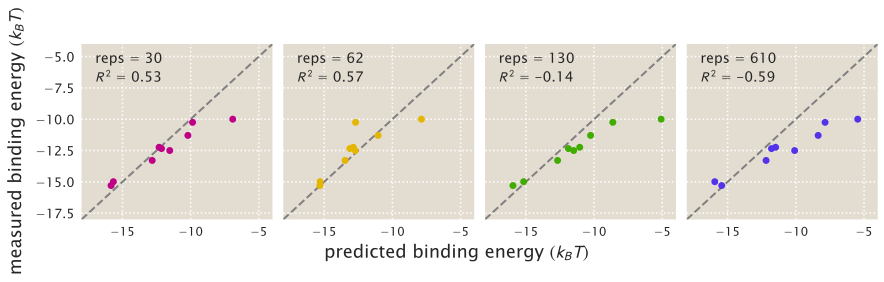

In [10]:
op = df['matrix_operator']=='O1'
fig, ax = plt.subplots(ncols=4, figsize=(12,3), sharey=True)

for i, rep_num in enumerate(df['matrix_repressor'].unique()):
    rep = df['matrix_repressor'] == rep_num
    predictions_list = df['energy_prediction'][op & rep][0:9]
    measured_list = df['energy_measurement'][op & rep][0:9]
    ax[i].plot([-18, -4], [-18, -4], '--', color='gray')
    ax[i].plot(predictions_list, measured_list, 'o', color=colors_qual[i])
    ax[i].annotate('reps = %i' % rep_num, (-17, -5.5), fontsize=14)
    ax[i].annotate(r'$R^2$ = %.2f' % r2_score(measured_list, predictions_list), (-17, -7), fontsize=14)
    ax[i].set_xlim(-18, -4)
    ax[i].set_ylim(-18, -4)

plt.figtext(0.5, -0.04, r'predicted binding energy $(k_BT)$', fontsize=18, ha='center')
plt.figtext(-0.02, 0.5, r'measured binding energy $(k_BT)$', rotation='vertical', fontsize=18, va='center')
plt.tight_layout()

## O2

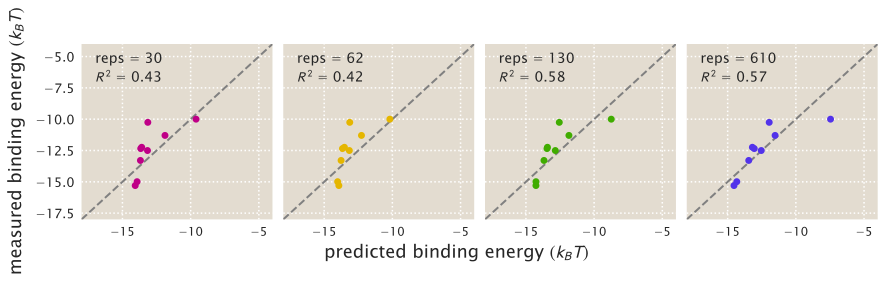

In [11]:
op = df['matrix_operator']=='O2'
fig, ax = plt.subplots(ncols=4, figsize=(12,3), sharey=True)

for i, rep_num in enumerate(df['matrix_repressor'].unique()):
    rep = df['matrix_repressor'] == rep_num
    predictions_list = df['energy_prediction'][op & rep][0:9]
    measured_list = df['energy_measurement'][op & rep][0:9]
    ax[i].plot([-18, -4], [-18, -4], '--', color='gray')
    ax[i].plot(predictions_list, measured_list, 'o', color=colors_qual[i])
    ax[i].annotate('reps = %i' % rep_num, (-17, -5.5), fontsize=14)
    ax[i].annotate(r'$R^2$ = %.2f' % r2_score(measured_list, predictions_list), (-17, -7), fontsize=14)
    ax[i].set_xlim(-18, -4)
    ax[i].set_ylim(-18, -4)

plt.figtext(0.5, -0.04, r'predicted binding energy $(k_BT)$', fontsize=18, ha='center')
plt.figtext(-0.02, 0.5, r'measured binding energy $(k_BT)$', rotation='vertical', fontsize=18, va='center')
plt.tight_layout()

## O3

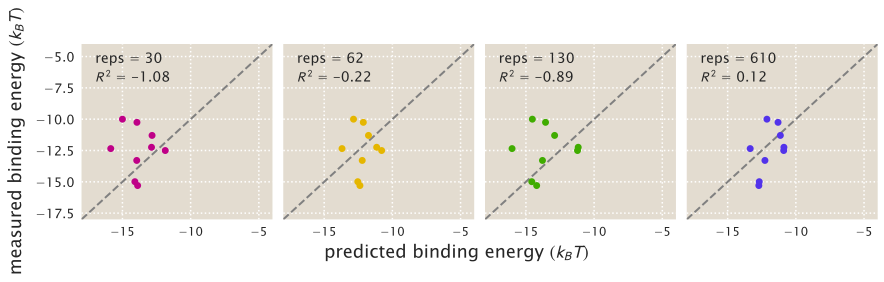

In [12]:
op = df['matrix_operator']=='O3'
fig, ax = plt.subplots(ncols=4, figsize=(12,3), sharey=True)

for i, rep_num in enumerate(df['matrix_repressor'].unique()):
    rep = df['matrix_repressor'] == rep_num
    predictions_list = df['energy_prediction'][op & rep][0:9]
    measured_list = df['energy_measurement'][op & rep][0:9]
    ax[i].plot([-18, -4], [-18, -4], '--', color='gray')
    ax[i].plot(predictions_list, measured_list, 'o', color=colors_qual[i])
    ax[i].annotate('reps = %i' % rep_num, (-17, -5.5), fontsize=14)
    ax[i].annotate(r'$R^2$ = %.2f' % r2_score(measured_list, predictions_list), (-17, -7), fontsize=14)
    ax[i].set_xlim(-18, -4)
    ax[i].set_ylim(-18, -4)

plt.figtext(0.5, -0.04, r'predicted binding energy $(k_BT)$', fontsize=18, ha='center')
plt.figtext(-0.02, 0.5, r'measured binding energy $(k_BT)$', rotation='vertical', fontsize=18, va='center')
plt.tight_layout()

Surprisingly, changing the number of repressors in the background strain produces no clear effect on energy matrix quality. 